In [1]:
# These two lines allow for the notebook to automatically update to use the most
# up-to-date versions of the code being imported
%load_ext autoreload
%autoreload 2

# General important stuff
import sys
sys.path.append('..')

import control as ct
import numpy as np
import matplotlib.pyplot as plt
from control_systems.control_core import *
from control_systems.calculate_laser_noise import *

# plt.style.available
%matplotlib inline
plt.style.use('science')
plt.rcParams['figure.figsize'] = [4,3]

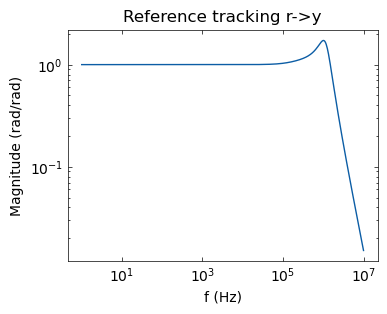

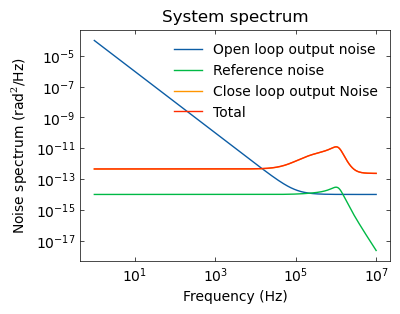

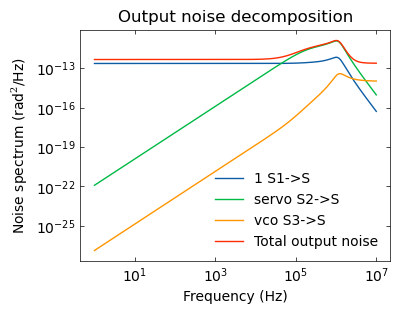

In [11]:
# architechture with the LO as an output
# r ---> D ---> PI ---> LO/VCO ---> y
#        |                |
#        ------------------
# assume both r and VCO have the same noise spectrum

K = 2*np.pi*30e6 # VCO gain 30MHz/V [Hz/V]
BW_vco = 1e6     # VCO BW 1MHz
Dphi = 0.6       # V/rad
S_pd = 8e-14     # photocetector noise [Hz^2/Hz]
freq_points = 500

D = ControlModule(freq_points = freq_points, sys_ref = 1, unit_in = 'rad', unit_out = 'rad', label = '1')
D.output_noise = np.ones(len(D.freqx))*S_pd/Dphi**2

s = ct.tf('s')
sys = 0.05*(1 + 2*np.pi*1.8e5/s)
servo = ControlModule(freq_points = freq_points, sys_ref = sys, unit_in = 'V', unit_out = 'V', label = 'servo')
servo.output_noise = np.ones(len(servo.freqx))*1e-14 # 1e-14 V^2/Hz

sys = K/s/(1+s/(2*np.pi*BW_vco))
vco = ControlModule(freq_points = freq_points, sys_ref = sys, unit_in = 'V', unit_out = 'rad', label = 'vco')
vco.output_noise = 1e-4/vco.freqx**2 + 1e-14*np.ones(len(vco.freqx))

C_list = [D, servo, vco]
pll = feedback_combine(C_list, 2)
pll.input_noise =  1e-14*np.ones(len(vco.freqx))
pll.freqresp_module_update()

pll.plot_ref_tracking()
pll.plot_module_noise()
pll.plot_module_noise_decomposition()

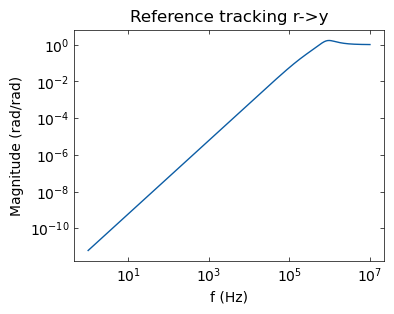

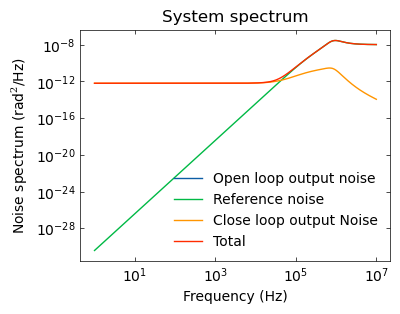

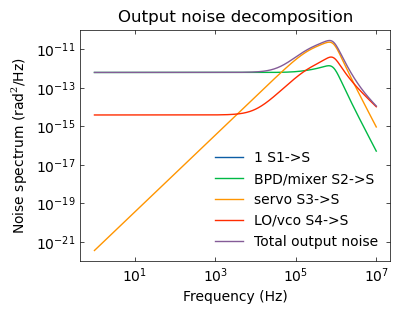

In [12]:
# architechture with the residual phase error as an output
# r ---> D1 ----------------> dphi
#        |                |
#      LO/VCO <-- PI <-- D2
# assume both r and VCO have the same noise spectrum

K = 2*np.pi*30e6 # VCO gain 30MHz/V [Hz/V]
BW_vco = 1e6     # VCO BW 1MHz
Dphi = 0.6       # V/rad
S_pd = 8e-14     # photocetector noise [V^2/Hz]
freq_points = 500

D1 = ControlModule(freq_points = freq_points, sys_ref = 1, unit_in = 'rad', unit_out = 'rad', label = '1')
D1.output_noise = np.ones(len(D1.freqx))*0.0

D2 = ControlModule(freq_points = freq_points, sys_ref = Dphi, unit_in = 'rad', unit_out = 'V', label = 'BPD/mixer')
D2.output_noise = np.ones(len(D2.freqx))*S_pd/Dphi**2

s = ct.tf('s')
sys = 0.05*(1 + 2*np.pi*1.8e5/s)
servo = ControlModule(freq_points = freq_points, sys_ref = sys, unit_in = 'V', unit_out = 'V', label = 'servo')
servo.output_noise = np.ones(len(servo.freqx))*1e-14 # 1e-14 V^2/Hz

sys = K/s/(1+s/(2*np.pi*BW_vco))
vco = ControlModule(freq_points = freq_points, sys_ref = sys, unit_in = 'V', unit_out = 'rad', label = 'LO/vco')
vco.output_noise = (1e8/vco.freqx**2 + 1)/vco.freqx**2

C_list = [D1, D2, servo, vco]
pll = feedback_combine(C_list, 0)
pll.input_noise =  1e-8*np.ones(len(D1.freqx))
pll.freqresp_module_update()

pll.plot_ref_tracking()
pll.plot_module_noise()
pll.plot_module_noise_decomposition()